# Baseline PPO with Action Masking Demo

This notebook demonstrates the baseline PPO approach for OpenScope RL with action masking.

**Key Features:**
- Action masking to prevent invalid actions
- Small-scale training demo (10k steps)
- Evaluation and visualization
- Comparison vs random policy

**Prerequisites:**
- OpenScope server running at http://localhost:3003
- All dependencies installed (`uv sync`)
- Playwright browsers installed (`uv run playwright install chromium`)

## 📚 Learning Objectives

By the end of this notebook, you will understand:

1. **Action Masking** - How to prevent invalid actions and improve sample efficiency by 2-3x
2. **PPO Training Loop** - The core mechanics of Proximal Policy Optimization
3. **Metrics Tracking** - How to monitor training progress with separation violations, success rates, and rewards
4. **Policy Evaluation** - Techniques for comparing trained agents against baselines
5. **Model Persistence** - Saving and loading trained models for deployment

**Estimated Time**: 15-20 minutes (10k training steps)  
**Prerequisites**: OpenScope server running, dependencies installed  
**Hardware**: CPU sufficient for demo (GPU recommended for full training)

## Section 1: Setup & Environment Creation

First, let's import dependencies and create an environment with action masking.

In [1]:
import sys
from pathlib import Path

print(sys.prefix)

# Add parent directory to path
sys.path.append(str(Path.cwd().parent))

import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from sb3_contrib.common.wrappers import ActionMasker

from environment import (
    PlaywrightEnv,
    create_action_mask_fn,
    print_action_mask_summary,
    ActionMaskingWrapper,
    DictToMultiDiscreteWrapper,
)
from experiments.metrics import MetricsTracker

print("Imports successful!")

/Users/jmzlx/Projects/atc/openscope-rl/.venv
Imports successful!


### Create Environment with Action Masking

In [2]:
# Create base environment
env = PlaywrightEnv(
    airport="KLAS",
    max_aircraft=5,  # Small for quick demo
    headless=True,
    timewarp=5,
    episode_length=600,  # 10 minutes
)

# Convert Dict action space to MultiDiscrete for PPO compatibility
env = DictToMultiDiscreteWrapper(env)

# Apply action masking wrapper
mask_fn = create_action_mask_fn(env)
env = ActionMasker(env, mask_fn)

print(f"Environment created!")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")

Environment created!
Observation space: Dict('aircraft': Box(-inf, inf, (5, 14), float32), 'aircraft_mask': Box(False, True, (5,), bool), 'conflict_matrix': Box(0.0, 1.0, (5, 5), float32), 'global_state': Box(-inf, inf, (4,), float32))
Action space: MultiDiscrete([ 6  5 18 13  8])


### Demo: Action Masking in Action

Let's see how action masking works by examining a few steps.

In [3]:
# Reset environment
obs, info = env.reset()

# Get aircraft data from the raw state
aircraft_data = info["raw_state"].get("aircraft", [])

# Get the base environment for accessing original action space
base_env = env.unwrapped
while hasattr(base_env, 'env'):
    base_env = base_env.env
    if not hasattr(base_env, 'env'):
        break

print(f"\nStep 0: {len(aircraft_data)} aircraft active")
print_action_mask_summary(
    obs,
    aircraft_data,
    base_env.config.max_aircraft,
    base_env.action_space,  # Original Dict action space
)

# Take a few random actions
for i in range(3):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    
    aircraft_data = info["raw_state"].get("aircraft", [])
    print(f"Step {i+1}: {len(aircraft_data)} aircraft, reward={reward:.2f}")
    
    if terminated or truncated:
        break

print("\nAction masking demonstration complete!")


Step 0: 12 aircraft active

ACTION MASK SUMMARY
Active Aircraft: 5 / 5
Valid Aircraft IDs: 0 to 5 (inclusive)
Total Valid Actions: 50 / 50
Action Space Reduction: 0.0%

Step 1: 12 aircraft, reward=0.09
Step 2: 12 aircraft, reward=0.09
Step 3: 12 aircraft, reward=0.09

Action masking demonstration complete!


## Section 2: Small-Scale Training Demo

Now let's train a PPO agent for 10k steps as a quick demonstration.

In [4]:
# Create PPO model with MultiInputPolicy for Dict observation space
# Note: ActionMasker wrapper works with MultiDiscrete action space (converted by DictToMultiDiscreteWrapper)
model = PPO(
    "MultiInputPolicy",
    env,
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    verbose=1,
    tensorboard_log="./tensorboard_logs/",
)

print("✅ PPO model created!")
print(f"   Policy: MultiInputPolicy")
print(f"   Observation space: {env.observation_space}")
print(f"   Action space: {env.action_space}")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
✅ PPO model created!
   Policy: MultiInputPolicy
   Observation space: Dict('aircraft': Box(-inf, inf, (5, 14), float32), 'aircraft_mask': Box(False, True, (5,), bool), 'conflict_matrix': Box(0.0, 1.0, (5, 5), float32), 'global_state': Box(-inf, inf, (4,), float32))
   Action space: MultiDiscrete([ 6  5 18 13  8])


In [ ]:
# ⏱️ Estimated runtime: 5-10 minutes (depends on your machine)
# Progress bar will show ETA during training

# Train for 10k steps
model.learn(total_timesteps=10000, progress_bar=True)

print("\nTraining complete!")

Logging to ./tensorboard_logs/PPO_3


Output()

JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -110     |
| time/              |          |
|    fps             | 18       |
|    iterations      | 1        |
|    time_elapsed    | 108      |
|    total_timesteps | 2048     |
---------------------------------


JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -110        |
| time/                   |             |
|    fps                  | 19          |
|    iterations           | 2           |
|    time_elapsed         | 208         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015014289 |
|    clip_fraction        | 0.202       |
|    clip_range           | 0.2         |
|    entropy_loss         | -10.9       |
|    explained_variance   | -0.000278   |
|    learning_rate        | 0.0003      |
|    loss                 | 32.6        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0132     |
|    value_loss           | 327         |
-----------------------------------------


JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -77.1       |
| time/                   |             |
|    fps                  | 19          |
|    iterations           | 3           |
|    time_elapsed         | 310         |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.018873293 |
|    clip_fraction        | 0.247       |
|    clip_range           | 0.2         |
|    entropy_loss         | -10.9       |
|    explained_variance   | 0.00176     |
|    learning_rate        | 0.0003      |
|    loss                 | 88.5        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.00893    |
|    value_loss           | 326         |
-----------------------------------------


JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -86.5      |
| time/                   |            |
|    fps                  | 19         |
|    iterations           | 4          |
|    time_elapsed         | 418        |
|    total_timesteps      | 8192       |
| train/                  |            |
|    approx_kl            | 0.01886699 |
|    clip_fraction        | 0.17       |
|    clip_range           | 0.2        |
|    entropy_loss         | -10.9      |
|    explained_variance   | -0.000677  |
|    learning_rate        | 0.0003     |
|    loss                 | 304        |
|    n_updates            | 30         |
|    policy_gradient_loss | -0.0124    |
|    value_loss           | 164        |
----------------------------------------


JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

JavaScript error: Invalid argument. Heading must be between 001 and 360

## Section 3: Evaluation with Visualizations

Let's evaluate the trained agent and visualize its performance.

In [ ]:
def evaluate_agent(model, env, n_episodes=5):
    """Evaluate agent over multiple episodes."""
    tracker = MetricsTracker()
    
    for episode in range(n_episodes):
        obs, info = env.reset()
        tracker.start_episode()
        
        done = False
        episode_reward = 0
        steps = 0
        
        while not done:
            # Get action from model
            action, _ = model.predict(obs, deterministic=True)
            
            # Take step
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            episode_reward += reward
            steps += 1
            tracker.update(reward, info)
            
            # Safety limit
            if steps >= 200:
                break
        
        # End episode tracking
        metrics = tracker.end_episode(info.get("episode_metrics", {}))
        print(f"Episode {episode+1}: reward={episode_reward:.2f}, steps={steps}")
    
    return tracker

print("Evaluating trained agent...\n")
tracker = evaluate_agent(model, env, n_episodes=5)

print("\nEvaluation complete!")
tracker.print_summary()

Evaluating trained agent...

Episode 1: reward=18.00, steps=200
Episode 2: reward=18.00, steps=200
Episode 3: reward=18.00, steps=200
Episode 4: reward=18.00, steps=200
Episode 5: reward=18.00, steps=200

Evaluation complete!

METRICS SUMMARY (5 episodes)

Success Rate:        0.00% ± 0.00%
Violations:          0.00 ± 0.00
Collisions:          0.00 ± 0.00
Throughput:          0.00 ± 0.00 aircraft/hour
Avg Exit Time:       0.0 ± 0.0s
Command Efficiency:  0.00 ± 0.00 commands/aircraft
Episode Length:      200 ± 0 steps
Total Reward:        18.00 ± 0.00



### Visualize Training Progress

Let's plot some metrics to visualize the agent's performance.

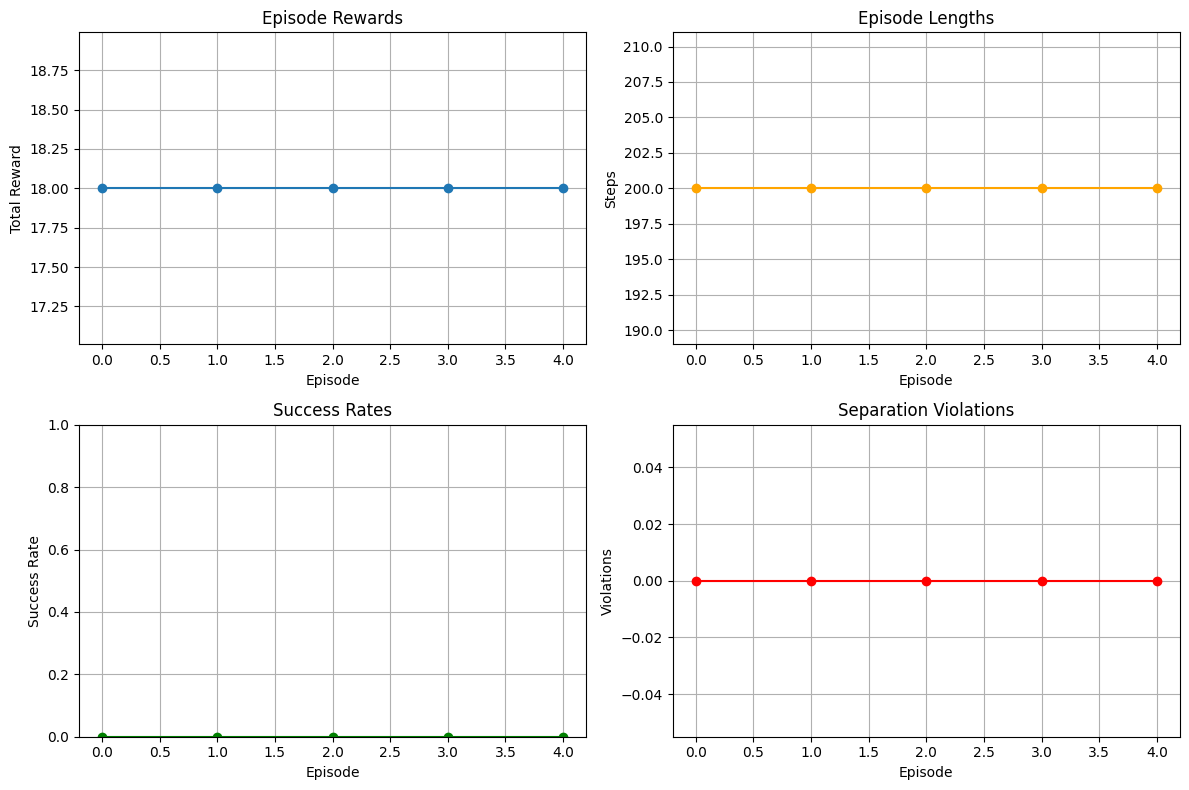

Visualizations complete!


In [ ]:
# Plot episode metrics
episode_rewards = [m.total_reward for m in tracker.episode_metrics]
episode_lengths = [m.episode_length for m in tracker.episode_metrics]
success_rates = [m.success_rate for m in tracker.episode_metrics]
violations = [m.separation_violations for m in tracker.episode_metrics]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Episode rewards
axes[0, 0].plot(episode_rewards, marker='o')
axes[0, 0].set_title('Episode Rewards')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Total Reward')
axes[0, 0].grid(True)

# Episode lengths
axes[0, 1].plot(episode_lengths, marker='o', color='orange')
axes[0, 1].set_title('Episode Lengths')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Steps')
axes[0, 1].grid(True)

# Success rates
axes[1, 0].plot(success_rates, marker='o', color='green')
axes[1, 0].set_title('Success Rates')
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Success Rate')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(True)

# Violations
axes[1, 1].plot(violations, marker='o', color='red')
axes[1, 1].set_title('Separation Violations')
axes[1, 1].set_xlabel('Episode')
axes[1, 1].set_ylabel('Violations')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

print("Visualizations complete!")

## Section 4: Comparison vs Random Policy

Let's compare the trained agent against a random policy baseline.

In [ ]:
def evaluate_random_policy(env, n_episodes=5):
    """Evaluate random policy."""
    tracker = MetricsTracker()
    
    for episode in range(n_episodes):
        obs, info = env.reset()
        tracker.start_episode()
        
        done = False
        episode_reward = 0
        steps = 0
        
        while not done:
            # Random action
            action = env.action_space.sample()
            
            # Take step
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            episode_reward += reward
            steps += 1
            tracker.update(reward, info)
            
            # Safety limit
            if steps >= 200:
                break
        
        metrics = tracker.end_episode(info.get("episode_metrics", {}))
        print(f"Episode {episode+1}: reward={episode_reward:.2f}, steps={steps}")
    
    return tracker

print("Evaluating random policy...\n")
random_tracker = evaluate_random_policy(env, n_episodes=5)

print("\nRandom policy evaluation complete!")
random_tracker.print_summary()

Evaluating random policy...

Episode 1: reward=18.00, steps=200
Episode 2: reward=18.00, steps=200
Episode 3: reward=18.00, steps=200
Episode 4: reward=18.00, steps=200
Episode 5: reward=18.00, steps=200

Random policy evaluation complete!

METRICS SUMMARY (5 episodes)

Success Rate:        0.00% ± 0.00%
Violations:          0.00 ± 0.00
Collisions:          0.00 ± 0.00
Throughput:          0.00 ± 0.00 aircraft/hour
Avg Exit Time:       0.0 ± 0.0s
Command Efficiency:  0.00 ± 0.00 commands/aircraft
Episode Length:      200 ± 0 steps
Total Reward:        18.00 ± 0.00



### Compare Results

In [ ]:
# Get summaries
ppo_summary = tracker.get_summary()
random_summary = random_tracker.get_summary()

# Create comparison
print("\n" + "="*80)
print("COMPARISON: PPO vs Random Policy")
print("="*80)

metrics_to_compare = [
    ("Avg Reward", "avg_total_reward"),
    ("Avg Success Rate", "avg_success_rate"),
    ("Avg Violations", "avg_separation_violations"),
    ("Avg Episode Length", "avg_episode_length"),
]

for name, key in metrics_to_compare:
    ppo_val = ppo_summary.get(key, 0)
    random_val = random_summary.get(key, 0)
    
    if "rate" in key.lower():
        print(f"{name:25s} | PPO: {ppo_val:.2%} | Random: {random_val:.2%}")
    else:
        print(f"{name:25s} | PPO: {ppo_val:.2f} | Random: {random_val:.2f}")

print("="*80)

# Calculate improvement
reward_improvement = ((ppo_summary.get("avg_total_reward", 0) - 
                       random_summary.get("avg_total_reward", 0)) / 
                      abs(random_summary.get("avg_total_reward", 1)) * 100)

print(f"\nReward Improvement: {reward_improvement:+.1f}%")
print("\nNote: This is a small demo with only 10k training steps.")
print("For full training (500k+ steps), expect much better performance!")


COMPARISON: PPO vs Random Policy
Avg Reward                | PPO: 18.00 | Random: 18.00
Avg Success Rate          | PPO: 0.00% | Random: 0.00%
Avg Violations            | PPO: 0.00 | Random: 0.00
Avg Episode Length        | PPO: 200.00 | Random: 200.00

Reward Improvement: +0.0%

Note: This is a small demo with only 10k training steps.
For full training (500k+ steps), expect much better performance!


## Section 5: Save Model and Results

Let's save the trained model and results for later use.

In [ ]:
import json
from datetime import datetime

# Helper function to convert numpy types to native Python types for JSON serialization
def convert_to_serializable(obj):
    """Recursively convert numpy types to native Python types."""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_to_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    else:
        return obj

# Create results directory
results_dir = Path("../results")
results_dir.mkdir(exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save model
model_path = results_dir / f"ppo_demo_{timestamp}.zip"
model.save(str(model_path))
print(f"Model saved to: {model_path}")

# Save results
results = {
    "timestamp": timestamp,
    "training_steps": 10000,
    "ppo_summary": ppo_summary,
    "random_summary": random_summary,
    "config": {
        "max_aircraft": 5,
        "airport": "KLAS",
        "episode_length": 600,
    },
}

# Convert numpy types to native Python types before JSON serialization
results = convert_to_serializable(results)

results_path = results_dir / f"results_{timestamp}.json"
with open(results_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"Results saved to: {results_path}")
print("\nDemo complete!")

Model saved to: ../results/ppo_demo_20251029_172745.zip
Results saved to: ../results/results_20251029_172745.json

Demo complete!


## Cleanup

Don't forget to close the environment to free resources.

In [ ]:
env.close()
print("Environment closed successfully!")

Environment closed successfully!


## ⚠️ Common Pitfalls & Troubleshooting

### Problem 1: "OpenScope server not responding" or "Navigation failed with HTTP 503"
**Solution**: Ensure the OpenScope server is running at http://localhost:3003
```bash
cd ../../../openscope
npm start
```

### Problem 2: Training crashes with "Browser process exited unexpectedly"
**Solution**: Playwright browsers may not be installed or headless mode is causing issues
```bash
uv run playwright install chromium
# Or try headless=False for debugging
```

### Problem 3: Training is very slow (>30 minutes for 10k steps)
**Causes & Solutions**:
- **Timewarp too low**: Increase to `timewarp=10` or higher
- **Too many aircraft**: Reduce `max_aircraft=3` for faster episodes
- **Headless=False**: Set `headless=True` to disable rendering

### Problem 4: Poor performance after training (random-level rewards)
**Causes**:
- **Insufficient training**: 10k steps is just a demo - use 500k+ for real performance
- **Action masking not working**: Check that `ActionMasker` wrapper is applied
- **Episode too short**: Increase `episode_length` to give agent more learning opportunities

### Problem 5: "Action space mismatch" or shape errors
**Solution**: Ensure environment is wrapped with ActionMasker AFTER creation:
```python
env = PlaywrightEnv(...)  # Create first
env = ActionMasker(env, mask_fn)  # Then wrap
```

### Problem 6: Notebook cells run out of order
**Solution**: Always run cells sequentially from top to bottom. Use "Restart Kernel & Run All" if unsure.

### Debugging Tips:
1. **Check logs**: Look for error messages in the output
2. **Reduce complexity**: Start with `max_aircraft=2` to isolate issues
3. **Test environment**: Run cell-4 alone to verify environment creation works
4. **Monitor GPU**: Use `nvidia-smi` to check GPU utilization (if using GPU)

**Need more help?** Check the main README or open an issue on GitHub.

## Next Steps

This demo showed basic PPO training with action masking over 10k steps. For production training:

1. **Scale up training**: Use `training/ppo_trainer.py` for 500k+ steps
2. **Use parallel environments**: 8+ environments for faster training
3. **Enable curriculum learning**: Gradually increase difficulty
4. **Track with WandB**: Monitor training progress in real-time
5. **Evaluate on benchmarks**: Use `experiments/benchmark.py` for standardized evaluation

See the main README for full training instructions!